In [95]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)


In [1]:
df = catalog.load('df_train')

2021-04-18 22:27:46,279 - kedro.io.data_catalog - INFO - Loading data from `df_train` (ParquetDataSet)...


In [2]:
categorical_cols = ['sex', 'residentialAddress_clean',
                    'postalAddress_clean', 'geo_risk_rank','shopID','same_address']
numerical_cols = ['age', 'income', 'price'] + \
    df.filter(regex='(^hist_)|(_lst_)').columns.to_list()

In [3]:
categorical_cols

['sex',
 'residentialAddress_clean',
 'postalAddress_clean',
 'geo_risk_rank',
 'shopID',
 'same_address']

In [4]:
numerical_cols

['age',
 'income',
 'price',
 'hist_trans_count',
 'hist_default_sum',
 'hist_default_avg',
 'hist_late_sum',
 'hist_late_avg',
 'hist_price_sum',
 'hist_price_avg',
 'default_lst_01_sum',
 'late_lst_01_sum',
 'price_lst_01_sum',
 'default_lst_01_avg',
 'late_lst_01_avg',
 'price_lst_01_avg',
 'default_lst_03_sum',
 'late_lst_03_sum',
 'price_lst_03_sum',
 'default_lst_03_avg',
 'late_lst_03_avg',
 'price_lst_03_avg',
 'default_lst_06_sum',
 'late_lst_06_sum',
 'price_lst_06_sum',
 'default_lst_06_avg',
 'late_lst_06_avg',
 'price_lst_06_avg',
 'default_lst_09_sum',
 'late_lst_09_sum',
 'price_lst_09_sum',
 'default_lst_09_avg',
 'late_lst_09_avg',
 'price_lst_09_avg',
 'default_lst_12_sum',
 'late_lst_12_sum',
 'price_lst_12_sum',
 'default_lst_12_avg',
 'late_lst_12_avg',
 'price_lst_12_avg']

# Category features

In [5]:
import numpy as np
from collections import Counter


In [6]:
def calculate_IV(column, default_column = 'default', default_val=1, nondefault_val=0, df=df, ifprt = False):
    """
    calculate IV - temporary implementation
    """
    total = df.shape[0]
    total_event = np.sum(df[default_column]==default_val)
    total_nonevent= np.sum(df[default_column]==nondefault_val)

    def total_prc(x): return np.round(len(x)/total,4)
    def event_prc(x): return  np.round(len([i for i in list(x) if i==default_val])/total_event,4)
    def nonevent_prc(x): return  np.round(len([i for i in list(x) if i==nondefault_val])/total_nonevent,4)
    def woe(x): return np.log(nonevent_prc(x)/(event_prc(x)+np.finfo(float).eps))
    def iv(x): return (nonevent_prc(x)-event_prc(x))*woe(x)

    wyn = df[[column,default_column]].groupby(column).agg(
        ['count',total_prc,event_prc, nonevent_prc, woe,iv
        ])

    if ifprt:
        print(wyn)
    IV = np.sum(wyn.iloc[:,-1])
    if ifprt:
        print("\n IV value of variable '{}' is {}".format(column,np.round(IV,4)))
    return IV, wyn

In [7]:
IV_cat = {}
repl_dic = {}

## Sex

In [8]:
IV_cat['sex'], repl_dic['sex'] = calculate_IV('sex', default_column='default')

2021-04-18 22:27:47,439 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


In [9]:
IV_cat['sex'], repl_dic['sex'] = calculate_IV('sex', default_column='late')

## geo_risk_rank

In [10]:
IV_cat['geo_risk_rank'], repl_dic['geo_risk_rank'] = calculate_IV('geo_risk_rank', default_column='default')

In [11]:
IV_cat['geo_risk_rank'], repl_dic['geo_risk_rank'] = calculate_IV('geo_risk_rank', default_column='late')

## same_address (postalAddress & residentialAddress)

In [12]:
IV_cat['same_address'], repl_dic['same_address'] = calculate_IV('same_address', default_column='default')

In [13]:
IV_cat['same_address'], repl_dic['same_address'] = calculate_IV('same_address', default_column='late')

## shopID

In [14]:
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

In [16]:
%matplotlib inline
shopID_pca = df.groupby('shopID').agg(
    default_rate=('default', 'mean'),
    age_avg=('age', 'mean'),
    price_avg=('price', 'mean'),
    income_avg=('income','mean')
)


scaler = MinMaxScaler()
X=scaler.fit_transform(shopID_pca)

#pc = PCA(n_components=2, random_state=1)
#X=pc.fit_transform(X)

X = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300, random_state=1).fit_transform(X)


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 899 samples in 0.000s...
[t-SNE] Computed neighbors for 899 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 899 / 899
[t-SNE] Mean sigma: 0.079524
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.732620
[t-SNE] KL divergence after 300 iterations: 1.355151


<AxesSubplot:xlabel='x', ylabel='y'>

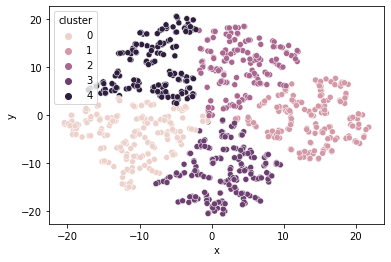

In [17]:
#clustering = DBSCAN(eps=0.07, min_samples=5).fit(X)
clustering = KMeans(n_clusters=5).fit(X)
set(clustering.labels_)

pca_clusters = pd.DataFrame(X, columns=['x','y']).assign(
    cluster=clustering.labels_, 
    dr=shopID_pca.default_rate)
sns.scatterplot(data=pca_clusters, x="x", y="y", hue="cluster")


In [18]:
shop_clusters = pd.DataFrame({'shopID':shopID_pca.index.to_list(), 'shop_cluster':clustering.labels_})
calculate_IV('shop_cluster', default_column='late', df=df.merge(shop_clusters, on='shopID', how='left'))

(4.697127959003095e-05,
                late                                                         
               count total_prc event_prc nonevent_prc           woe        iv
 shop_cluster                                                                
 0             67810    0.2199    0.2206       0.2196 -4.543397e-03  0.000005
 1             64337    0.2087    0.2071       0.2093  1.056686e-02  0.000023
 2             55393    0.1796    0.1809       0.1791 -1.000008e-02  0.000018
 3             65331    0.2119    0.2115       0.2120  2.361276e-03  0.000001
 4             55476    0.1799    0.1799       0.1799 -1.221245e-15 -0.000000)

## residentialAddress_clean

In [19]:
residentialAddress_clean_pca = df.groupby('residentialAddress_clean').agg(
    default_rate=('default', 'mean'),
    age_avg=('age', 'mean'),
    price_avg=('price', 'mean'),
    income_avg=('income','mean')
)

scaler = MinMaxScaler()
X=scaler.fit_transform(residentialAddress_clean_pca)

X = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300, random_state=1).fit_transform(X)



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13260 samples in 0.006s...
[t-SNE] Computed neighbors for 13260 samples in 0.553s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13260
[t-SNE] Computed conditional probabilities for sample 2000 / 13260
[t-SNE] Computed conditional probabilities for sample 3000 / 13260
[t-SNE] Computed conditional probabilities for sample 4000 / 13260
[t-SNE] Computed conditional probabilities for sample 5000 / 13260
[t-SNE] Computed conditional probabilities for sample 6000 / 13260
[t-SNE] Computed conditional probabilities for sample 7000 / 13260
[t-SNE] Computed conditional probabilities for sample 8000 / 13260
[t-SNE] Computed conditional probabilities for sample 9000 / 13260
[t-SNE] Computed conditional probabilities for sample 10000 / 13260
[t-SNE] Computed conditional probabilities for sample 11000 / 13260
[t-SNE] Computed conditional probabilities for sample 12000 / 13260
[t-SNE] Computed conditional probabilities for sam

<AxesSubplot:xlabel='x', ylabel='y'>

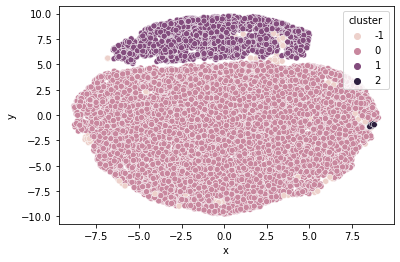

In [20]:
%matplotlib inline
clustering = DBSCAN(eps=0.32, min_samples=10).fit(X)
#clustering = KMeans(n_clusters=2).fit(X)
#clustering = AgglomerativeClustering(n_clusters=4).fit(X)
set(clustering.labels_)

pca_clusters = pd.DataFrame(X, columns=['x','y']).assign(
    cluster=clustering.labels_, 
    dr=residentialAddress_clean_pca.default_rate)
sns.scatterplot(data=pca_clusters, x="x", y="y", hue="cluster")



In [21]:
residentialAddress_clusters = pd.DataFrame({'residentialAddress_clean': residentialAddress_clean_pca.index.to_list(), 
              'residentialAddress_cluster':clustering.labels_})

calculate_IV('residentialAddress_cluster', default_column='late', df=df.merge(residentialAddress_clusters, on='residentialAddress_clean', how='left'))


(0.0005175305441338978,
                               late                                             \
                              count total_prc event_prc nonevent_prc       woe   
 residentialAddress_cluster                                                      
 -1                            1615    0.0052    0.0051       0.0053  0.038466   
  0                          270447    0.8771    0.8722       0.8791  0.007880   
  1                           36114    0.1171    0.1222       0.1150 -0.060727   
  2                             171    0.0006    0.0005       0.0006  0.182322   
 
                                       
                                   iv  
 residentialAddress_cluster            
 -1                          0.000008  
  0                          0.000054  
  1                          0.000437  
  2                          0.000018  )

# Numerical

In [23]:
import matplotlib


In [26]:
from sklearn.preprocessing import KBinsDiscretizer

In [105]:
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

In [106]:
num2cat_raw = df.query("rank>1").reset_index(drop=True)[numerical_cols+['default','late']].drop(columns=['income'])
num2cat_raw_y = num2cat_raw['default']
num2cat_raw_y_late = num2cat_raw['late']
num2cat_raw = num2cat_raw.drop(columns=['default','late'])
num2cat_ord = est.fit_transform(num2cat_raw)
num2cat = pd.DataFrame(num2cat_ord, columns=num2cat_raw.columns)

/Users/xszpo/miniconda3/envs/viabill/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
/Users/xszpo/miniconda3/envs/viabill/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
/Users/xszpo/miniconda3/envs/viabill/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
/Users/xszpo/miniconda3/envs/viabill/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:220

In [107]:
IV_num = {}
df_IV_num = {}

for col in num2cat.columns.to_list():
    IV_num[col], df_IV_num[col] = calculate_IV(col, default_column='default', df=pd.concat([num2cat,num2cat_raw_y], axis=1))


In [108]:
pd.DataFrame([(i,IV_num[i]) for i in IV_num], columns=['feature', 'iv']).sort_values('iv', ascending=False).query("iv>0.01")


,feature,iv
30,default_lst_09_avg,0.188553
4,hist_default_avg,0.188512
36,default_lst_12_avg,0.188512
21,default_lst_06_sum,0.183091
24,default_lst_06_avg,0.183091
33,default_lst_12_sum,0.181681
3,hist_default_sum,0.181681
27,default_lst_09_sum,0.181542


In [113]:
best_numerical_default = pd.DataFrame([(i,IV_num[i]) for i in IV_num], columns=['feature', 'iv']).sort_values('iv', ascending=False).query("iv>0.01").reset_index(drop=True)
best_numerical_default

,feature,iv
0,default_lst_09_avg,0.188553
1,hist_default_avg,0.188512
2,default_lst_12_avg,0.188512
3,default_lst_06_sum,0.183091
4,default_lst_06_avg,0.183091
5,default_lst_12_sum,0.181681
6,hist_default_sum,0.181681
7,default_lst_09_sum,0.181542


In [110]:
IV_num_late = {}
df_IV_num_late = {}

for col in num2cat.columns.to_list():
    IV_num_late[col], df_IV_num_late[col] = calculate_IV(col, default_column='late', df=pd.concat([num2cat,num2cat_raw_y_late], axis=1))


In [114]:
best_numerical_late = pd.DataFrame([(i,IV_num_late[i]) for i in IV_num_late], columns=['feature', 'iv']).sort_values('iv', ascending=False).query("iv>0.01")
best_numerical_late


,feature,iv
22,late_lst_06_sum,0.145606
25,late_lst_06_avg,0.145206
37,late_lst_12_avg,0.144519
6,hist_late_avg,0.144519
28,late_lst_09_sum,0.144467
31,late_lst_09_avg,0.144437
5,hist_late_sum,0.144364
34,late_lst_12_sum,0.144364
19,late_lst_03_avg,0.144144
16,late_lst_03_sum,0.127930


In [119]:
list_bnd = best_numerical_default.feature.to_list()+['income']

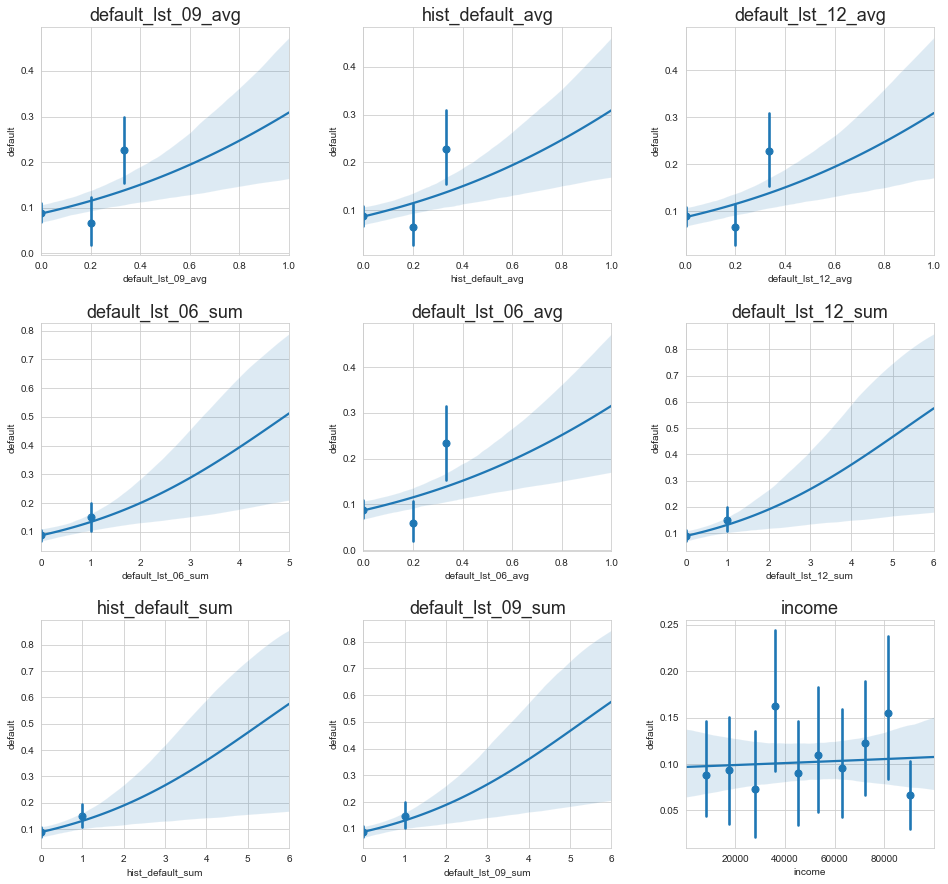

In [120]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(16,26))
gs = matplotlib.gridspec.GridSpec(nrows=5, 
                       ncols=3, 
                       figure=fig, 
                       wspace=0.3,
                       hspace=0.3)

ax_dic = {}




counter = 0
for row in range(5):
    for col in range(3):
        if counter < len(list_bnd):
            col_name = list_bnd[counter]
            ax_dic[counter] = fig.add_subplot(gs[row, col])
            sns.regplot(x=col_name, y="default",logistic=True,y_jitter=.03,
                        data=df.sample(1000, random_state=666), x_bins=10, ax=ax_dic[counter])
            ax_dic[counter].set_title(col_name,fontsize=18)
            counter +=1
        

In [122]:
list_bnl = best_numerical_late.feature.to_list()+['income']

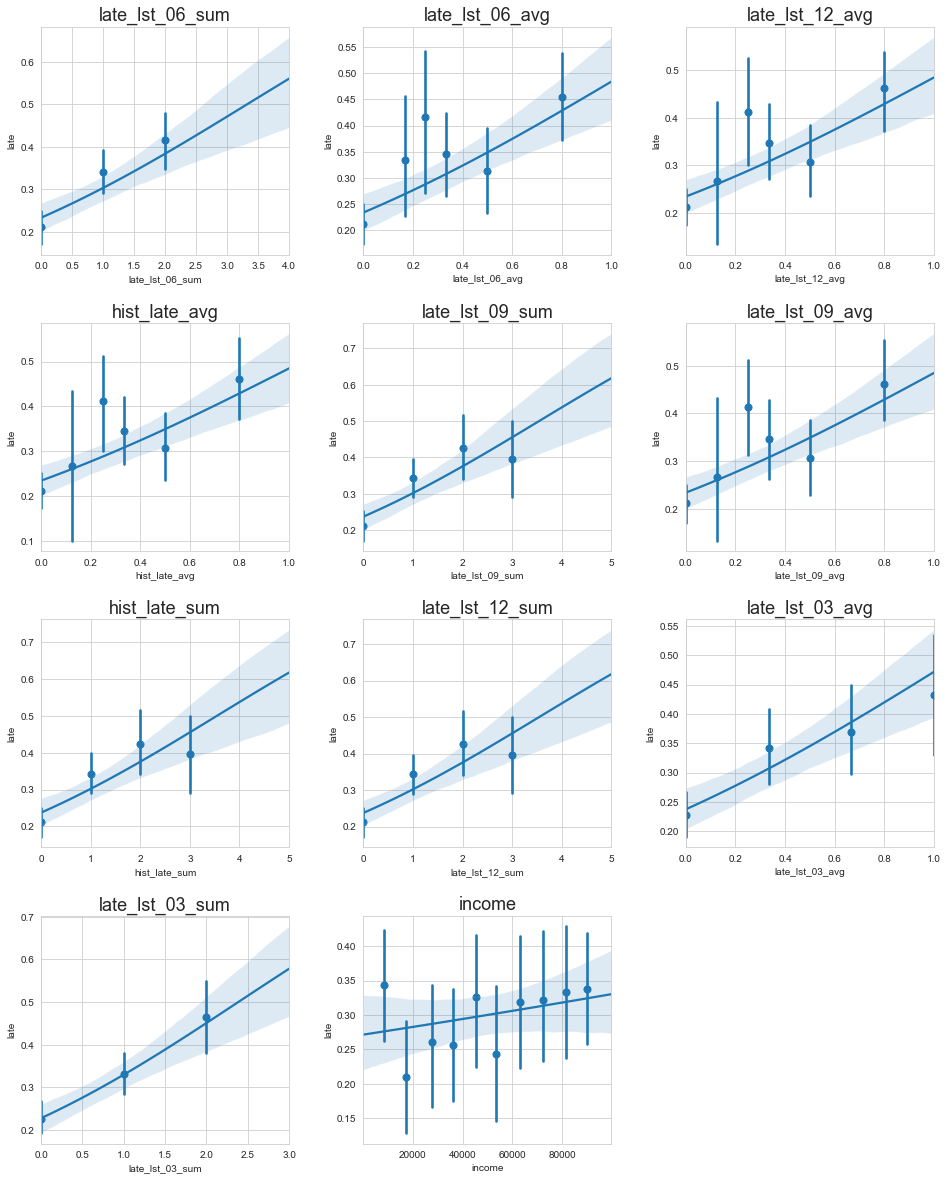

In [124]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(16,26))
gs = matplotlib.gridspec.GridSpec(nrows=5, 
                       ncols=3, 
                       figure=fig, 
                       wspace=0.3,
                       hspace=0.3)

ax_dic = {}




counter = 0
for row in range(5):
    for col in range(3):
        if counter < len(list_bnl):
            col_name = list_bnl[counter]
            ax_dic[counter] = fig.add_subplot(gs[row, col])
            sns.regplot(x=col_name, y="late",logistic=True,y_jitter=.03,
                        data=df.sample(1000, random_state=666), x_bins=10, ax=ax_dic[counter])
            ax_dic[counter].set_title(col_name,fontsize=18)
            counter +=1
        